In [416]:
import sys
#sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
from numpy import inf
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc
from tqdm import tqdm_notebook, tqdm 
import matplotlib.pyplot as plt
import datetime
import json
from scipy import stats
import holidays
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [199]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
mapping = pd.read_csv('./data/building_metadata.csv')

In [200]:
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')

In [201]:
### Add Holidays ###
def get_holidays(df):
    en_holidays = holidays.England()
    ir_holidays = holidays.Ireland()
    ca_holidays = holidays.Canada()
    us_holidays = holidays.UnitedStates()
    en_idx = df.query('site_id == 1 or site_id == 5').index
    ir_idx = df.query('site_id == 12').index
    ca_idx = df.query('site_id == 7 or site_id == 11').index
    us_idx = df.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index
    df['IsHoliday'] = 0
    df.loc[en_idx, 'IsHoliday'] = df.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df.loc[ir_idx, 'IsHoliday'] = df.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df.loc[ca_idx, 'IsHoliday'] = df.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df.loc[us_idx, 'IsHoliday'] = df.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))
    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)
    
    return df

In [202]:
weather_train = get_holidays(weather_train)
weather_test = get_holidays(weather_test)

In [203]:
timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
weather_train['timediff']= weather_train['site_id'].map(timediff)
weather_test['timediff']= weather_test['site_id'].map(timediff)

weather_train['timediff'] = weather_train['timediff'].apply(lambda x: datetime.timedelta(hours=x))
weather_test['timediff'] = weather_test['timediff'].apply(lambda x: datetime.timedelta(hours=x))

weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

weather_train['timestamp'] = weather_train['timestamp'] - weather_train['timediff']
weather_test['timestamp'] = weather_test['timestamp'] - weather_test['timediff']

In [204]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,timediff
0,0,2015-12-31 20:00:00,25.000,6.000,20.000,nan,1019.700,0.000,0.000,1,04:00:00
1,0,2015-12-31 21:00:00,24.400,nan,21.100,-1.000,1020.200,70.000,1.500,1,04:00:00
2,0,2015-12-31 22:00:00,22.800,2.000,21.100,0.000,1020.200,0.000,0.000,1,04:00:00
3,0,2015-12-31 23:00:00,21.100,2.000,20.600,0.000,1020.100,0.000,0.000,1,04:00:00
4,0,2016-01-01 00:00:00,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1,04:00:00


In [205]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [207]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [208]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [157]:
del weather_train 
del weather_test

In [211]:
df_train = df_train.drop(['timediff'], axis = 1)
df_test = df_test.drop(['timediff'], axis = 1)

In [476]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [123]:
# Check one building
df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [214]:
### Intrapolate cloud coverage
df_train['cloud_coverage'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1,limit_direction = "both", limit = 1000))
df_test['cloud_coverage'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both", limit = 1000))

In [ ]:
### Intrapolate air temperature
df_train['air_temperature'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['air_temperature'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [ ]:
df_train.head()

In [ ]:
#### Take a Sample ####
#df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=1)
#df_test = df_test.sample(n=int(df_test.shape[0]*0.1), random_state=1)

In [ ]:
#df_train["Month"] = pd.to_datetime(df_train["timestamp"]).dt.month
#df_test["Month"] = pd.to_datetime(df_test["timestamp"]).dt.month

In [ ]:
df_train["Day"] = pd.to_datetime(df_train["timestamp"]).dt.day
df_test["Day"] = pd.to_datetime(df_test["timestamp"]).dt.day

In [ ]:
df_train["Hour"] = pd.to_datetime(df_train["timestamp"]).dt.hour
df_test["Hour"] = pd.to_datetime(df_test["timestamp"]).dt.hour

In [ ]:
#df_train.to_csv("df_train.csv", index = False)
#df_test.to_csv("df_test.csv", index = False)

In [ ]:
#df_train = pd.read_csv('./df_train.csv')
#df_test = pd.read_csv('./df_test.csv')

In [ ]:
plt.plot(pd.to_datetime(df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['timestamp']).dt.date, df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['precip_depth_1_hr'])

In [ ]:
df_train['precip_depth_1_hr'] = df_train.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['precip_depth_1_hr'] = df_test.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['sea_level_pressure'] = df_train.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['sea_level_pressure'] = df_test.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_direction'] = df_train.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_direction'] = df_test.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['wind_speed'] = df_train.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_speed'] = df_test.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train['dew_temperature'] = df_train.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['dew_temperature'] = df_test.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [ ]:
df_train["DayOfWeek"] = pd.to_datetime(df_train["timestamp"]).dt.dayofweek
df_test["DayOfWeek"] = pd.to_datetime(df_test["timestamp"]).dt.dayofweek

In [ ]:
df_train.head()

In [ ]:
#df_train = dp.create_stats_features(df_train, 'dew_temperature', ['site_id', 'Month'])
#df_test = dp.create_stats_features(df_test, 'dew_temperature', ['site_id', 'Month'])

In [ ]:
#df_train["air_temperature_log"] = np.log(df_train['air_temperature'])
#df_test["air_temperature_log"] = np.log(df_test['air_temperature'])

In [ ]:
#df_train["Age"] = pd.to_datetime(df_train["timestamp"]).dt.year - df_train["year_built"]
#df_test["Age"] = pd.to_datetime(df_test["timestamp"]).dt.year - df_test["year_built"]

In [ ]:
### Clean Electricity ###
df_train = df_train[~((df_train['site_id'] == 0) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-20 18:00:00')))]

In [ ]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-01 12:00:00')))]
df_train = df_train[~((df_train['building_id'] == 802) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-23 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 803) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')))]

In [237]:
df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')
df_test.to_csv("df_test.csv.gz", index = False, compression = 'gzip')

In [617]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [293]:
### Lags for cloud coverage and air temperature
#for i in range(12):
#    df_train[f'cloud_coverage_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_test[f'cloud_coverage_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_train[f'air_temperature_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)
#    df_test[f'air_temperature_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)

In [618]:
### Drop zero values in Electricity ###
df_train = df_train.drop(df_train[(df_train['meter'] == 0) 
                       & (df_train['meter_reading'] == 0.0)].index)

In [693]:
### calculate relative humididty ###
df_train['relative_humidity'] = 100-5*(df_train['air_temperature'] - df_train['dew_temperature'])
df_test['relative_humidity'] = 100-5*(df_test['air_temperature'] - df_test['dew_temperature'])

In [708]:
def create_add_features(df):
    df['air_density_dry'] = df['sea_level_pressure']/(287.058 * df['air_temperature'])
    df['vapor_pressure_water_satur'] = 6.102*10**((7.5*df['air_temperature'])/(df['air_temperature']+237.8))
    df['vapor_pressure_water'] =  df['relative_humidity']*df['vapor_pressure_water_satur']
    df['partial_press_dry'] = df['sea_level_pressure']-df['vapor_pressure_water'] 
    df['air_density_humid'] = (df['partial_press_dry']*0.0289654+df['vapor_pressure_water'] *0.018016)/8.314*df['air_temperature']
    
    return df

In [709]:
df_train = create_add_features(df_train)
df_test = create_add_features(df_test)

In [295]:
### Log of Square fit plus year build ###
#df_train['year_built'] = df_train['year_built'] - 1900
#df_train['square_feet'] = np.log(df_train['square_feet'])
#df_test['year_built'] = df_test['year_built'] - 1900
#df_test['square_feet'] = np.log(df_test['square_feet'])

In [500]:
def roll_diff(x):
    return x[0] - x[-1]

In [501]:
def check_constants(grp):
    grp['is_constant_meter'] = grp['meter_reading'].rolling(6).apply(roll_diff)
    return grp

In [502]:
# calculate rolling diff for constant detection
#df_train = df_train.groupby(['building_id', 'meter'], as_index = False).apply(lambda x: check_constants(x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



In [503]:
df_train.shape

(19682552, 21)

In [504]:
# convert constant meter readings to nan
#df_train.loc[df_train['is_constant_meter'] == 0.0, 'meter_reading'] = np.nan
#df_train = df_train[df_train['is_constant_meter'] != 0.0]

In [351]:
#df_train['meter_reading'].isnull().sum()
#df_train.shape

2255180

In [439]:
#def replace_na_with_prophet(df):
#    
#    test_prof = df[['timestamp', 'meter_reading', 'air_temperature']]
#    test_prof.columns = ["ds", "y", "air_temperature"]
#    z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#    z.add_regressor('air_temperature')
#    z.fit(test_prof)
#    forecast = z.predict(test_prof)
#    df = df.reset_index(drop = True)
#    df['meter_reading'] = forecast['yhat']
    
#    #print(f'Itheration {i} is finished')
    
#    return(df)

In [429]:
#test_prft = df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)]

In [ ]:
# Replace constants with prophet
#%time df_train = df_train.groupby(['building_id', 'meter'], as_index=False).apply(lambda x: replace_na_with_prophet(x))

In [ ]:
#df_train = df_train.reset_index(drop = True)

In [ ]:
#df_train.to_csv("df_train_prophet_for_constants.csv.gz", index = False, compression = 'gzip')

In [637]:
df_train[(df_train['site_id'] == 1) & (df_train['meter'] == 3)]['building_id'].unique()

array([106, 109, 112, 113, 114, 117, 119, 121, 138, 139, 144, 145])

In [303]:
# Intrapolate nan values of meter reading 
#test['meter_reading'] = test.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "piecewise_polynomial", order = 5, limit_direction = "both"))
#def rolling_interpol(df):
#    roll_wind = df['meter_reading'].isnull().sum()
#    if roll_wind == 0:
#        pass
#    else:
#        df['meter_reading'] = df.meter_reading.fillna(df.meter_reading.rolling(roll_wind, min_periods=1).mean())
#    return df

In [304]:
#df_train = df_train.groupby(['building_id', 'meter']).apply(lambda x : rolling_interpol(x))

In [354]:
#df_train['meter_reading'] = df_train.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [620]:
df_train[df_train['meter_reading'].isnull()].shape

(0, 20)

In [648]:
test = df_train[(df_train['meter'] ==  3) & (df_train['building_id'] == 138)] 

In [639]:
#test_prof = test[['timestamp', 'meter_reading', 'air_temperature', 'cloud_coverage', 'wind_direction',
#                 'sea_level_pressure']]
#test_prof.columns = ["ds", "y", "air_temperature", "cloud_coverage", "wind_direction", "sea_level_pressure"]

#### Testing Prophet ####

#z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#z.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#z.add_regressor('wind_direction')
#z.add_regressor('air_temperature')
#z.add_regressor('cloud_coverage')
#z.add_regressor('sea_level_pressure')
#z.fit(test_prof)
#forecast = z.predict(test_prof)

In [640]:
#rmsle(test_prof['y'],forecast['yhat'])

In [641]:
#plt.figure(figsize=(15,15))
#plt.plot(pd.to_datetime(forecast["ds"]).dt.date, forecast['yhat'])

In [642]:
#test = test.reset_index(drop = True)
#test['meter_reading'] = forecast['yhat']

In [686]:
test = df_train.copy()

In [673]:
#x = test['wind_direction'].value_counts()

In [696]:
test.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity
0,105,0,2016-01-01 00:00:00,23.304,1,Education,50623,nan,5.000,3.800,-0.130,2.400,nan,1020.900,240.000,3.100,1.000,1,0,4,93.000
1,106,0,2016-01-01 00:00:00,0.375,1,Education,5374,nan,4.000,3.800,-0.130,2.400,nan,1020.900,240.000,3.100,1.000,1,0,4,93.000
2,106,3,2016-01-01 00:00:00,0.000,1,Education,5374,nan,4.000,3.800,-0.130,2.400,nan,1020.900,240.000,3.100,1.000,1,0,4,93.000
3,107,0,2016-01-01 00:00:00,175.184,1,Education,97532,2005.000,10.000,3.800,-0.130,2.400,nan,1020.900,240.000,3.100,1.000,1,0,4,93.000
4,108,0,2016-01-01 00:00:00,91.265,1,Education,81580,1913.000,5.000,3.800,-0.130,2.400,nan,1020.900,240.000,3.100,1.000,1,0,4,93.000


In [683]:
test = dp.create_stats_features(test, ['air_temperature'], ['site_id', 'Hour'])

In [688]:
test['relative_humidity'] = 100-5*(test['air_temperature'] - test['dew_temperature'])
test['air_density_dry'] = test['sea_level_pressure']/(287.058 * test['air_temperature'])
test['vapor_pressure_water_satur'] = 6.102*10**((7.5*test['air_temperature'])/(test['air_temperature']+237.8))
test['vapor_pressure_water'] =  test['relative_humidity']*test['vapor_pressure_water_satur']
test['partial_press_dry'] = test['sea_level_pressure']-test['vapor_pressure_water'] 
test['air_density_humid'] = (test['partial_press_dry']*0.0289654+test['vapor_pressure_water'] *0.018016)/8.314*test['air_temperature']

In [706]:
test.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water,vapor_pressure_water_satur,partial_press_dry,air_density_humid
building_id,1.000,0.211,0.009,0.980,0.086,-0.214,-0.364,-0.316,-0.155,-0.101,0.055,0.085,0.048,0.009,0.001,-0.003,-0.000,-0.000,0.326,0.003,0.175,-0.313,-0.177,-0.326
meter,0.211,1.000,0.018,0.244,0.133,0.020,0.185,-0.007,-0.142,-0.074,0.019,-0.049,-0.024,-0.081,0.001,-0.002,0.000,-0.000,-0.091,-0.002,-0.085,0.018,0.082,0.047
meter_reading,0.009,0.018,1.000,0.012,0.025,0.132,0.136,-0.004,0.011,-0.003,-0.000,-0.004,0.000,0.006,-0.001,-0.000,0.001,-0.001,0.001,0.000,-0.001,-0.005,0.001,-0.002
site_id,0.980,0.244,0.012,1.000,0.090,-0.182,-0.351,-0.308,-0.121,-0.127,0.051,0.062,0.051,0.016,0.001,-0.003,-0.000,-0.000,0.278,0.003,0.131,-0.293,-0.135,-0.294
square_feet,0.086,0.133,0.025,0.090,1.000,0.146,0.573,-0.015,-0.002,-0.022,0.040,-0.019,-0.017,-0.035,-0.000,-0.001,0.000,0.000,-0.008,-0.004,-0.004,0.001,0.002,-0.017
year_built,-0.214,0.020,0.132,-0.182,0.146,1.000,0.135,0.170,0.083,0.100,-0.022,-0.032,-0.063,-0.048,0.002,0.004,0.000,-0.000,-0.100,-0.005,-0.003,0.166,-0.002,0.063
floor_count,-0.364,0.185,0.136,-0.351,0.573,0.135,1.000,-0.177,-0.212,-0.164,0.153,-0.045,0.072,-0.019,-0.002,-0.002,-0.000,0.001,0.046,0.013,-0.112,-0.183,0.117,-0.078
air_temperature,-0.316,-0.007,-0.004,-0.308,-0.015,0.170,-0.177,1.000,-0.010,0.751,0.017,-0.314,-0.099,-0.086,-0.055,0.026,0.156,-0.006,-0.445,-0.007,0.096,0.933,-0.096,0.509
cloud_coverage,-0.155,-0.142,0.011,-0.121,-0.002,0.083,-0.212,-0.010,1.000,0.064,0.050,-0.113,0.013,0.193,-0.005,0.006,0.040,-0.000,0.100,-0.002,0.070,0.006,-0.076,-0.063
dew_temperature,-0.101,-0.074,-0.003,-0.127,-0.022,0.100,-0.164,0.751,0.064,1.000,0.089,-0.222,-0.173,-0.144,-0.043,0.026,-0.008,-0.005,0.257,0.007,0.643,0.609,-0.643,-0.033


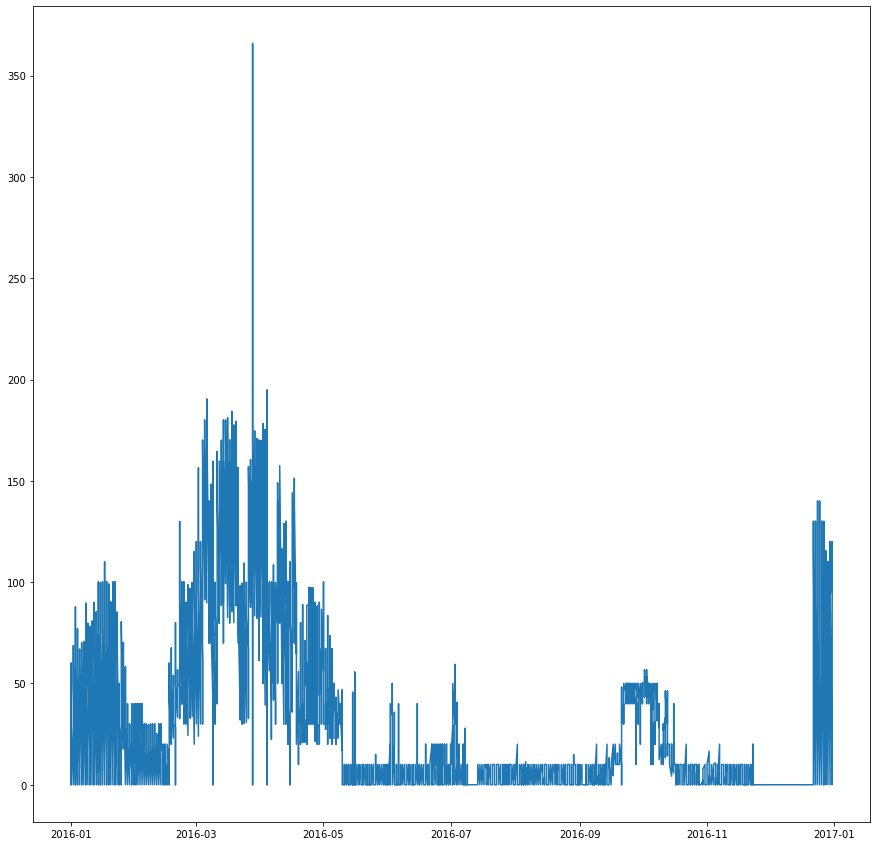

In [644]:
plt.figure(figsize=(15,15))
plt.plot(pd.to_datetime(test["timestamp"]).dt.date, test['meter_reading'])

In [235]:
### Testing Prophet ###
#test_ts = test[['timestamp', 'meter_reading']]
#test_ts['timestamp'] = pd.to_datetime(test_ts["timestamp"])
#test_ts = test_ts.set_index('timestamp')
#test_ts = test_ts.meter_reading.fillna(test_ts.meter_reading.rolling(969,min_periods=1).mean())
#test_ts.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [ ]:
#test_ts.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [172]:
################ Manual check of singe buildings ##################
df_train_elec = df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)] 
df_train_elec_test = df_train_elec[df_train_elec['building_id'] == 753]

In [173]:
df_train_elec.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,is_constant_meter
3022992,7,1,2016-02-29 09:00:00,1857.260,0,Education,121074,1989.000,nan,13.300,9.635,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022993,9,1,2016-02-29 09:00:00,590.945,0,Office,27000,2010.000,nan,13.300,9.347,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022994,13,1,2016-02-29 09:00:00,1224.100,0,Education,99380,2000.000,nan,13.300,7.035,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022995,14,1,2016-02-29 09:00:00,1435.150,0,Education,86250,2013.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022996,15,1,2016-02-29 09:00:00,422.104,0,Office,83957,1974.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan


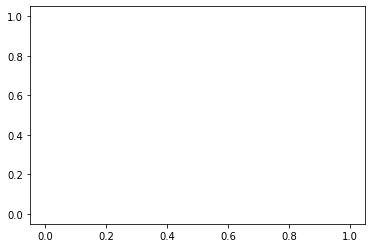

In [148]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [149]:
#df_train_elec['building_id'].unique()

array([  7,   9,  13,  14,  15,  29,  30,  31,  43,  50,  55,  60,  75,
        76,  78,  82,  91,  92,  95,  96,  97, 103,  28,  98])

In [150]:
#test = df_train_elec.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
#df_train_elec_test[(np.abs(stats.zscore(df_train_elec_test['meter_reading'])) < 5)]
#test.shape

In [203]:
#df_train_elec = df_train[(df_train['meter'] ==  1) & (df_train['building_id'] == 7)] 

In [152]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')]

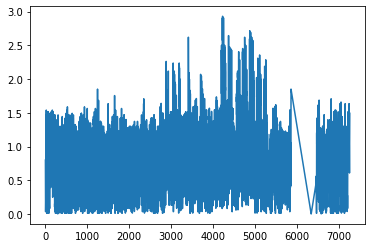

In [154]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [155]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-05-20 17:00:00')].head(30) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


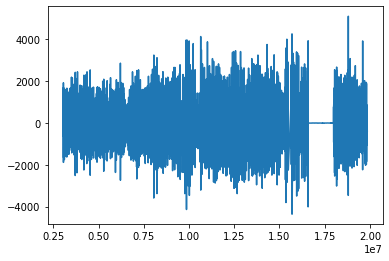

In [204]:
#plt.plot(df_train_elec['meter_reading'].rolling(2).apply(roll_diff))

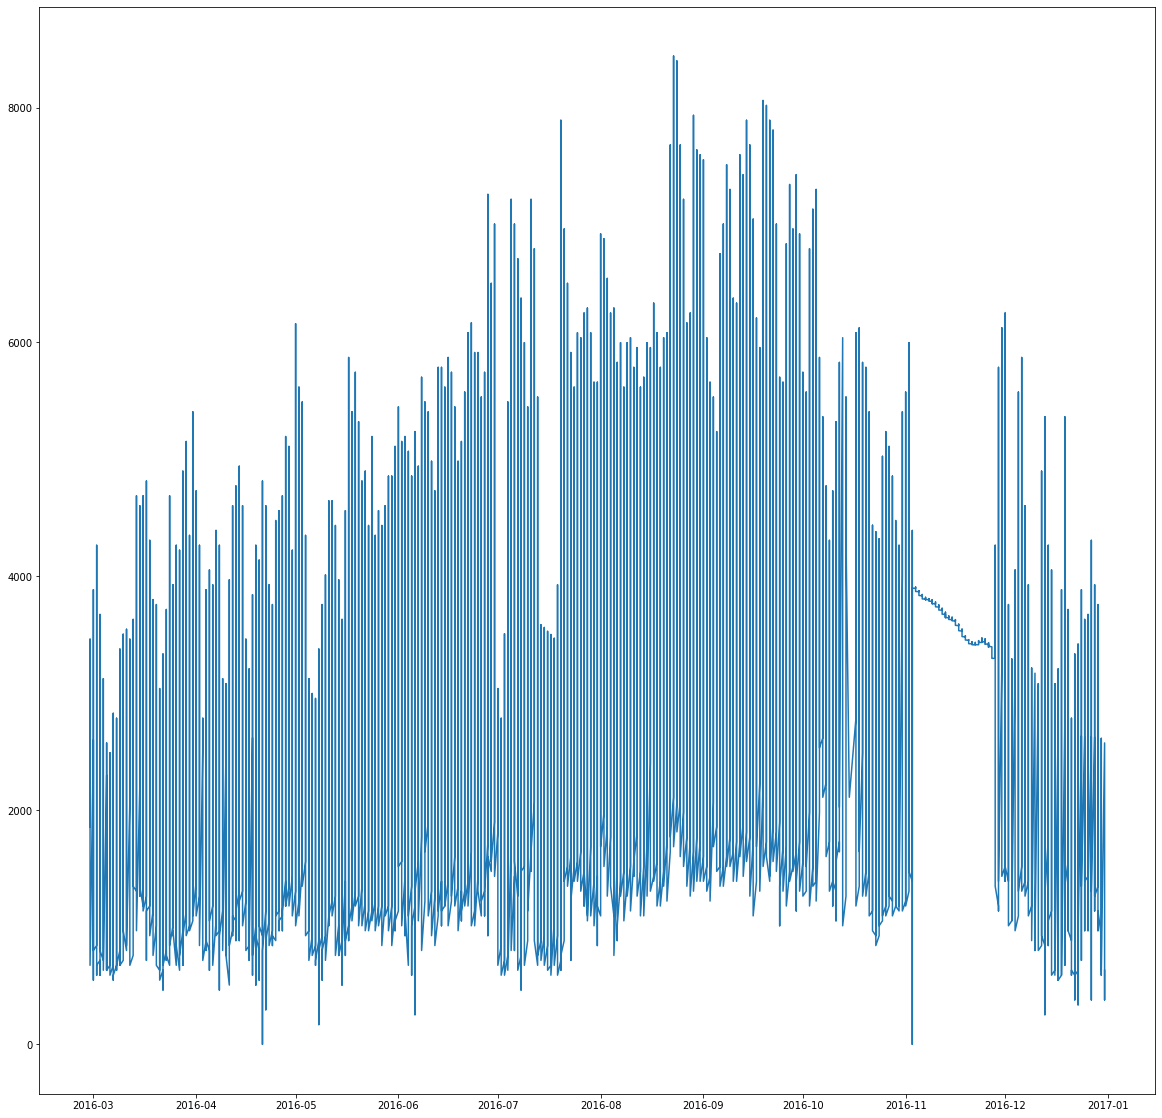

In [205]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(df_train_elec["timestamp"]).dt.date, df_train_elec['meter_reading'])

In [879]:
#df_train = df_train[df_train["meter_reading"] != 0.0]

In [880]:
#encode_cols = ["primary_use"]

In [881]:
#data = dp.encode_categorical(df_train, df_test, encode_cols) 

In [882]:
#mb = mc.modelBuilder('regression', 'LGBM')

In [883]:
#data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                             target = 'meter_reading', rem_cols = ['timestamp'], 
#                             useVarImp = False, varimp_threshold = 100)

In [884]:
#data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)

In [ ]:
#data['Y'] = np.log(data['Y'])

In [102]:
#data['Y'][data['Y'] == -inf] = 0

In [ ]:
#data['Y'].describe()

In [447]:
def rmse(y, yhat):
    score = sqrt(mean_squared_error(y, yhat))
    return(score)

In [694]:
# LGBM
params = {
    'boosting_type':'gbdt',
    'n_estimators':500,
    'num_leaves':64, 
    'objective':'regression_l2', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.1,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'rmse', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':1234,
    'lambda_l2': 1.5,
    'verbose' : 2,
    #'reg_alpha':0.0,
    #'reg_lambda':0.0, 
    #'silent':True, 
    'subsample':1.0
    #,
    #'early_stopping_round' : 100
}

In [10]:
### CatBoost params
params = {
    'iterations':500,
    'learning_rate' : 0.3,
    'depth' : 9,
    'loss_function' : 'RMSE',
    'verbose' : 2,
    'eval_metric': 'RMSE',
}

In [11]:
#gc.collect()

In [12]:
#df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [13]:
#df_train_build.head(20)

In [14]:
#submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                      save_varimp = True, params = params, oversmp = False, cv_shuffle=False)

In [692]:
df_train = df_train.drop(['is_constant_meter'], axis = 1)

KeyError: "['is_constant_meter'] not found in axis"

In [456]:
df_train[df_train['meter_reading'] < 0]['meter_reading'] = 0 

In [ ]:
#### Replace Constants with Prophet ####
df_train_final = pd.read_csv('./df_train_prophet_for_constants.csv', compression = 'gzip')
df_train_prophet = df_train_final[['timestamp', 'building_id', 'meter', 'meter_reading']]
df_train_prophet.columns = ['timestamp', 'building_id', 'meter', 'meter_reading_prophet']
df_train = df_train.merge(df_train_prophet, on = ['timestamp', 'building_id', 'meter'])
df_train.meter_reading.fillna(df_train.meter_reading_prophet, inplace=True)
df_train = df_train.drop(['meter_reading_prophet','is_constant_meter'], axis = 1)

In [710]:
### Per site and meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(7, 8, 1)):
    print(f'training site_id {i}')
    
    df_train_site = df_train[df_train['site_id'] == i]
    df_test_site = df_test[df_test['site_id'] == i]
    
    for j in df_train_site['meter'].unique():
        
        print(f'training meter {j}')
        df_train_metr = df_train_site[df_train_site['meter'] == j]
        df_test_metr = df_test_site[df_test_site['meter'] == j]

        df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
        data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
        data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp'], 
                                 useVarImp = False, varimp_threshold = 100)
        data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
        data['Y'] = np.log(data['Y'])
        data['Y'][data['Y'] == -inf] = 0
        submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
        submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
        final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

        perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
        final_sub_lst.append(final_submit)
    

training site_id 1
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.8326047180713008
Fold: 1
The valuation metric for the fold 1 is 0.7921175107209715
Fold: 2
The valuation metric for the fold 2 is 1.2063673095934413
The average score accross the folds is 0.9436965127952378
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.6236768100306627
Fold: 1
The valuation metric for the fold 1 is 1.797666749460673
Fold: 2
The valuation metric for the fold 2 is 1.8394623736122868
The average score accross the folds is 1.7536019777012075
training site_id 2
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5135022604851452
Fold: 1
The valuation metric for the fold 1 is 0.352731338642081
Fold: 2
The valuation metric for the fold 2 is 0.40482026709309327
The average score accross the folds is 0.4236846220734399
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.3877721614656489
Fold: 1
The valuation metric for the fold 1 is 1.2430045347785024
Fold: 2
The valuation metric for the fold 2 is 1.3281306050046116
The average score accross the folds is 1.3196357670829209
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.224923531727544
Fold: 1
The valuation metric for the fold 1 is 0.8138957929555094
Fold: 2
The valuation metric for the fold 2 is 1.1410395135813955
The average score accross the folds is 1.0599529460881498
training site_id 3
training meter 0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.56074853089407
Fold: 1
The valuation metric for the fold 1 is 0.42895072982989824
Fold: 2
The valuation metric for the fold 2 is 0.5237996507292901
The average score accross the folds is 0.5044996371510861
training site_id 4
training meter 0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.24247908564574186
Fold: 1
The valuation metric for the fold 1 is 0.2793464272688806
Fold: 2
The valuation metric for the fold 2 is 0.26815887535917854
The average score accross the folds is 0.2633281294246003
training sit

/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.335487440970925
Fold: 1
The valuation metric for the fold 1 is 0.36724134049370194
Fold: 2
The valuation metric for the fold 2 is 0.38054415965507576
The average score accross the folds is 0.3610909803732342
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.140675335877884
Fold: 1
The valuation metric for the fold 1 is 1.3131345533545293
Fold: 2
The valuation metric for the fold 2 is 2.356181661960851
The average score accross the folds is 1.936663850397755
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.6015751385854875
Fold: 1
The valuation metric for the fold 1 is 2.0089004450557812
Fold: 2
The valuation metric for the fold 2 is 1.8780300301149957
The average score accross the folds is 1.829501871252088
training site_id 7
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.2444167408945368
Fold: 1
The valuation metric for the fold 1 is 1.5526659446286484
Fold: 2
The valuation metric for the fold 2 is 1.6262698434847036
The average score accross the folds is 1.4744508430026297
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.5214260297108146
Fold: 1
The valuation metric for the fold 1 is 1.535544459231291
Fold: 2
The valuation metric for the fold 2 is 1.8353136910119516
The average score accross the folds is 1.630761393318019
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.16255285158138838
Fold: 1
The valuation metric for the fold 1 is 0.8271283386214976
Fold: 2
The valuation metric for the fold 2 is 2.1808712605676077
The average score accross the folds is 1.0568508169234978
training meter 3
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.3992761374353917
Fold: 1
The valuation metric for the fold 1 is 2.5912038483125484
Fold: 2
The valuation metric for the fold 2 is 2.1119781907473993
The average score accross the folds is 2.0341527254984464
training site_id 8
training meter 0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.7724733398430782
Fold: 1
The valuation metric for the fold 1 is 0.7080454527428398
Fold: 2
The valuation metric for the fold 2 is 0.6797390814153486
The average score accross the folds is 0.7200859580004222
training site_id 9
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.3550988931515289
Fold: 1
The valuation metric for the fold 1 is 1.395240217931881
Fold: 2
The valuation metric for the fold 2 is 1.47161746490992
The average score accross the folds is 1.4073188586644434
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.5416867873999096
Fold: 1
The valuation metric for the fold 1 is 1.4584200543278643
Fold: 2
The valuation metric for the fold 2 is 1.4891787370215888
The average score accross the folds is 1.4964285262497876
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.2703813857839293
Fold: 1
The valuation metric for the fold 1 is 0.20535103443645597
Fold: 2
The valuation metric for the fold 2 is 0.2530401466701469
The average score accross the folds is 0.24292418896351073
training site_id 10
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.43933474563281644
Fold: 1
The valuation metric for the fold 1 is 0.420314247924727
Fold: 2
The valuation metric for the fold 2 is 0.5011411751062546
The average score accross the folds is 0.4535967228879327
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.098975148079018
Fold: 1
The valuation metric for the fold 1 is 1.6752521600518844
Fold: 2
The valuation metric for the fold 2 is 1.9378145106574842
The average score accross the folds is 1.904013939596129
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.184177314591487
Fold: 1
The valuation metric for the fold 1 is 2.048200492877797
Fold: 2
The valuation metric for the fold 2 is 2.2727623724857366
The average score accross the folds is 2.1683800599850067
training site_id 11
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.14372628963718256
Fold: 1
The valuation metric for the fold 1 is 0.22216829104759325
Fold: 2
The valuation metric for the fold 2 is 0.19359736436822192
The average score accross the folds is 0.1864973150176659
training meter 3
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.7766069652061496
Fold: 1
The valuation metric for the fold 1 is 1.3910745463696716
Fold: 2
The valuation metric for the fold 2 is 1.1828627764265252
The average score accross the folds is 1.1168480960007823
training meter 1
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.4904369139838464
Fold: 1
The valuation metric for the fold 1 is 1.9511168733869155
Fold: 2
The valuation metric for the fold 2 is 1.227646362543395
The average score accross the folds is 1.2230667166380522
training site_id 12
training meter 0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3025550721099166
Fold: 1
The valuation metric for the fold 1 is 0.33280720803102704
Fold: 2
The valuation metric for the fold 2 is 0.3131290430566361
The average score accross the folds is 0.31616377439919324
training site_id 13
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.330331755297885
Fold: 1
The valuation metric for the fold 1 is 0.3656597392144313
Fold: 2
The valuation metric for the fold 2 is 0.37278285712407266
The average score accross the folds is 0.3562581172121296
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.181234203964493
Fold: 1
The valuation metric for the fold 1 is 0.9995623459047144
Fold: 2
The valuation metric for the fold 2 is 1.1283181391908996
The average score accross the folds is 1.1030382296867023
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.6643686858003737
Fold: 1
The valuation metric for the fold 2 is 2.0191635377609747
The average score accross the folds is 1.8908069105868925
training meter 3
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 2.2061987725355263
Fold: 1
The valuation metric for the fold 1 is 1.6887844425830454
Fold: 2
The valuation metric for the fold 2 is 2.1877483649709295
The average score accross the folds is 2.0275771933631668
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.9655967035207922
Fold: 1
The valuation metric for the fold 1 is 1.4853667755510183
Fold: 2
The valuation metric for the fold 2 is 2.215750724623694
The average score accross the folds is 1.888904734565168
training site_id 15
training meter 3
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.6597021694818689
Fold: 1
The valuation metric for the fold 1 is 0.719373904009933
Fold: 2
The valuation metric for the fold 2 is 0.6722226140648272
The average score accross the folds is 0.683766229185543
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.2806084115103511
Fold: 1
The valuation metric for the fold 1 is 0.2849509567048901
Fold: 2
The valuation metric for the fold 2 is 0.32014718181022767
The average score accross the folds is 0.2952355166751563
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.7003809064593672
Fold: 1
The valuation metric for the fold 1 is 0.600528595955481
Fold: 2
The valuation metric for the fold 2 is 0.6595819152525573
The average score accross the folds is 0.6534971392224685
training meter 2
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.0833108884535747
Fold: 1
The valuation metric for the fold 1 is 1.2945630325628041
Fold: 2
The valuation metric for the fold 2 is 0.8744480066922706
The average score accross the folds is 1.0841073092362166
training site_id 0
training meter 1
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.2069148929405737
Fold: 1
The valuation metric for the fold 1 is 1.9047363638086106
Fold: 2
The valuation metric for the fold 2 is 2.4276372053698663
The average score accross the folds is 2.1797628207063497
training meter 0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.31911558079951696
Fold: 1
The valuation metric for the fold 1 is 0.2912764743832644
Fold: 2
The valuation metric for the fold 2 is 0.408249324977809
The average score accross the folds is 0.3395471267201968


In [ ]:
### Per meter type ###
#perf_dict = {}
#final_sub_lst = []
#encode_cols = ["primary_use"]
#mb = mc.modelBuilder('regression', 'LGBM')
#for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(2)):
#    print(f'training site_id {i}')
#    
#    df_train_site = df_train[df_train['site_id'] == i]
#    df_test_site = df_test[df_test['site_id'] == i]

#    data = dp.encode_categorical(df_train_site, df_test_site, encode_cols)
#    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                                 target = 'meter_reading', rem_cols = ['timestamp'], 
#                                 useVarImp = False, varimp_threshold = 100)
#    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
#    data['Y'] = np.log(data['Y'])
#    data['Y'][data['Y'] == -inf] = 0
#    submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
#    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
#    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

#    perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
#    final_sub_lst.append(final_submit)
    

In [711]:
np.array(list(perf_dict.values())).mean()

1.1126944256948046

In [712]:
perf_dict

{'site_id: 1 and meter: 0': 0.9436965127952378,
 'site_id: 1 and meter: 3': 1.7536019777012075,
 'site_id: 2 and meter: 0': 0.4236846220734399,
 'site_id: 2 and meter: 1': 1.3196357670829209,
 'site_id: 2 and meter: 3': 1.0599529460881498,
 'site_id: 3 and meter: 0': 0.5044996371510861,
 'site_id: 4 and meter: 0': 0.2633281294246003,
 'site_id: 5 and meter: 0': 1.0339934683942655,
 'site_id: 6 and meter: 0': 0.3610909803732342,
 'site_id: 6 and meter: 2': 1.936663850397755,
 'site_id: 6 and meter: 1': 1.829501871252088,
 'site_id: 7 and meter: 1': 1.4744508430026297,
 'site_id: 7 and meter: 2': 1.630761393318019,
 'site_id: 7 and meter: 0': 1.0568508169234978,
 'site_id: 7 and meter: 3': 2.0341527254984464,
 'site_id: 8 and meter: 0': 0.7200859580004222,
 'site_id: 9 and meter: 1': 1.4073188586644434,
 'site_id: 9 and meter: 2': 1.4964285262497876,
 'site_id: 9 and meter: 0': 0.24292418896351073,
 'site_id: 10 and meter: 0': 0.4535967228879327,
 'site_id: 10 and meter: 1': 1.9040139395

In [495]:
with open('rmse_siteid_meter_no_zeros_prophet_const.txt', 'w') as file:
     file.write(json.dumps(perf_dict))

In [496]:
sub = pd.concat(final_sub_lst, axis = 0).reset_index(drop = True)
sub.to_csv("submit_lightgbm_by_site_3fold_prophet_const.csv.gz", index = False, compression='gzip')

In [ ]:
#submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])

In [ ]:
#submit['FinalPrediction']

In [ ]:
#submit

In [ ]:
#final_submit = pd.concat([df_test['row_id'], pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

In [ ]:
#final_submit["meter_reading"].describe()

In [ ]:
#final_submit.to_csv("submit_lightgbm_default.csv.gz", index = False, compression='gzip')

In [497]:
!kaggle competitions submit -c ashrae-energy-prediction -f submit_lightgbm_by_site_3fold_prophet_const.csv.gz -m "lightgbm replace constant with prophet 3 folds"

100%|████████████████████████████████████████| 475M/475M [00:09<00:00, 50.2MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III